In [1]:
%load_ext autoreload
%autoreload 2

# Getting Started 
Make sure your select ***ros_base*** as your kernel. You can do this by clicking on the kernel dropdown menu and selecting *ros_base*.


## Import Python dependencies

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation, cm
from IPython.display import HTML
import numpy as np
import csv

import tqdm as tqdm


plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

from ILQR import RefPath
from ILQR import ILQR



In [13]:
import yaml
goal_locations = {}
goal_path = []
with open('task1.yaml', 'r') as file:
            goal_configs = yaml.safe_load(file)
            for i in range(1, 13):
                goal_locations[i] = goal_configs[f'goal_{i}']
            goal_path.append(goal_configs['goal_order'])

print(goal_locations)

{1: [3.15, 0.15], 2: [3.15, 0.47], 3: [5.9, 3.5], 4: [5.6, 3.5], 5: [0.15, 3.5], 6: [0.45, 3.5], 7: [3, 1.1], 8: [3, 0.8], 9: [3, 2.2], 10: [0.75, 2.1], 11: [0.75, 4.3], 12: [4.6, 4.6]}


In [3]:
def load_path(filepath: str):
    """
    Gets the centerline of the track from the trajectory data. We currently only
    support 2D track.

    Args:
        filepath (str): the path to file consisting of the centerline position.

    Returns:
        np.ndarray: centerline, of the shape (2, N).
    """
    x = []
    y = []
    with open(filepath) as f:
        spamreader = csv.reader(f, delimiter=',')
        for i, row in enumerate(spamreader):
            if i > 0:
                x.append(float(row[0]))
                y.append(float(row[1]))

    return np.array([x, y])

## Generate a reference trajectory

In [4]:
# Define the file paths
config_file = 'task1/task1.yaml'
track_path = 'task1/ref_path.csv'

# Load the reference path
x = []
y = []
left_width = []
right_width = []
with open(track_path, newline='') as f:
    spamreader = csv.reader(f, delimiter=',')
    for i, row in enumerate(spamreader):
        if i>0:
            x.append(float(row[0]))
            y.append(float(row[1]))
            left_width.append(float(row[3]))
            right_width.append(float(row[2]))
            
x = np.array(x)/30.0
y = np.array(y)/30.0
left_width = np.array(left_width)
right_width = np.array(right_width)
center_line = np.array([x,y])


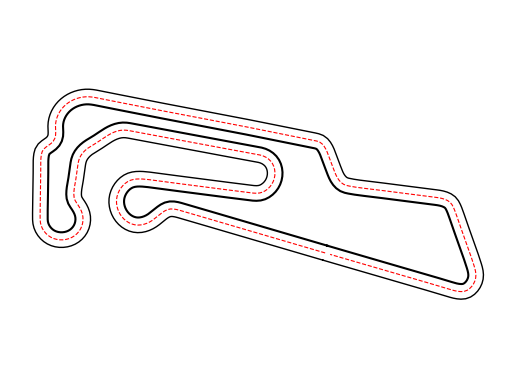

In [5]:
# Create a reference path
ref_path = RefPath(center_line, width_left = 0.6, width_right = 0.6, speed_limt = 5, loop = True)

# Visualize the reference path
ref_path.plot_track(linewidth = 1)
ref_path.plot_track_center(linewidth = 0.8, c='r')
plt.axis('equal')
_ = plt.axis('off')


## Test your ILQR planner
The planner need to warmup for a few steps for the first time it is run. This process will takes 10-30 seconds depending on your computer.

In [6]:
ilqr = ILQR(config_file)
ilqr.update_ref_path(ref_path)


Line Search Alphas:  [10.    1.    0.1   0.01]
ILQR setting: ILQR config: {'num_dim_x': 5, 'num_dim_u': 2, 'T': 10, 'dt': 0.1, 'platform': 'cpu', 'max_iter': 50, 'tol': 0.05, 'line_search_base': 0.1, 'line_search_a': -1, 'line_search_b': 3, 'line_search_c': 1, 'reg_min': '1e-5', 'reg_max': '1e8', 'reg_scale_down': 5, 'reg_scale_up': 5, 'reg_init': 1.0, 'max_attempt': 5, 'wheelbase': 0.257, 'radius': 0.13, 'width': 0.22, 'length': 0.4, 'delta_max': 0.35, 'delta_min': -0.35, 'v_max': 5.0, 'v_min': 0.0, 'omega_min': -6.0, 'omega_max': 6.0, 'a_max': 5.0, 'a_min': -5.0, 'v_ref': 5.0, 'dim_closest_pt_x': 0, 'dim_closest_pt_y': 1, 'dim_path_slope': 2, 'path_cost_type': 'quadratic', 'path_weight': 2.0, 'path_huber_delta': 2, 'vel_cost_type': 'quadratic', 'vel_weight': 0.2, 'vel_huber_delta': 1, 'dim_vel_limit': 3, 'vel_limit_a': 10.0, 'vel_limit_b': 1.0, 'heading_cost_type': 'quadratic', 'heading_weight': 1, 'heading_huber_delta': 1, 'lat_accel_thres': 6.0, 'lat_accel_a': 5.0, 'lat_accel_b': 2

### Plan for one step

Converged after 10 steps.


Text(0.5, 1.0, 'Lateral Acceleration')

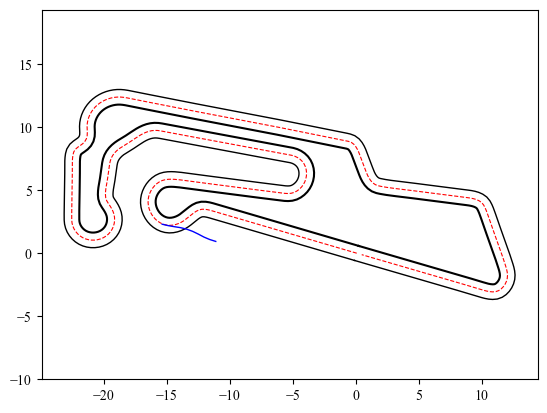

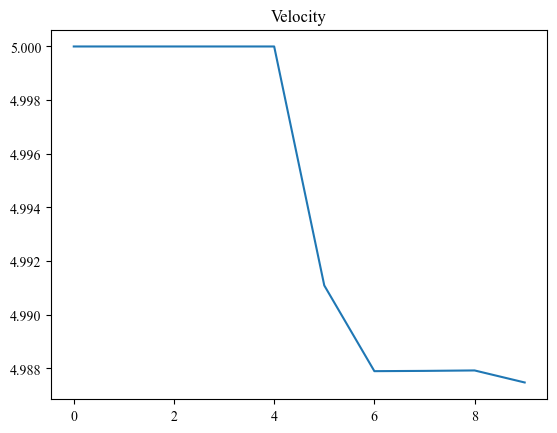

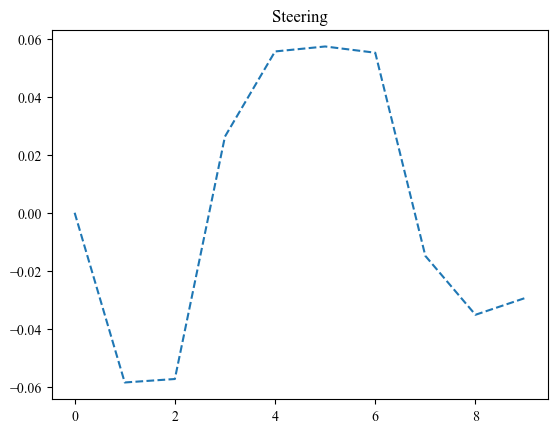

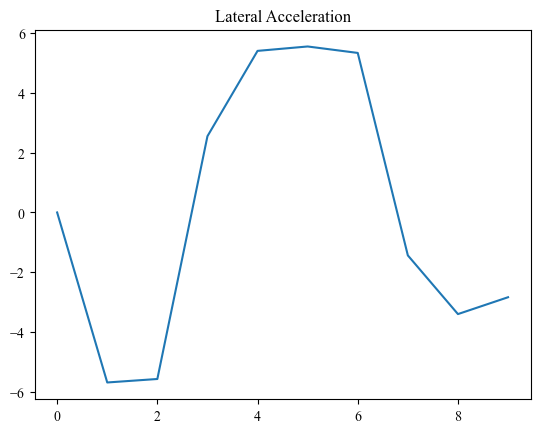

In [7]:
# Create an ILQR solver
x_init = np.array([x[70], y[20], 5, np.arctan2(y[61]-y[60], x[61]-x[60]), 0])
plan = ilqr.plan(x_init)

# Visualize the reference path
ref_path.plot_track(linewidth = 1)
ref_path.plot_track_center(linewidth = 0.8, c='r')
plt.plot(plan['trajectory'][0, :], plan['trajectory'][1, :], 'b-', linewidth=1)
plt.axis('equal')

plt.figure()
a = plan['trajectory'][2, :] 
plt.plot(a)
plt.title('Velocity')

plt.figure()
# plt.plot(plan['controls'][0,:])
plt.plot(plan['trajectory'][-1,:], '--')
plt.title('Steering')

plt.figure()
a = plan['trajectory'][2, :]**2 / 0.257 * np.tan(plan['trajectory'][-1, :])
plt.plot(a)
plt.title('Lateral Acceleration')


### Plan for the entire track

In [8]:
itr_receding = 400
init_control = np.zeros((2, ilqr.T))
x_cur = np.array([x[0], y[0], 4, np.arctan2(y[1]-y[0], x[1]-x[0]), 0])
state_history = np.zeros((5,itr_receding + 1))
state_history[:,0] = x_cur
plan_history = np.zeros((5, ilqr.T, itr_receding))
control_history = np.zeros((2,itr_receding))
t_process = np.zeros(itr_receding)
for i in (pbar := tqdm.tqdm(range(itr_receding))):
    plan = ilqr.plan(x_cur, init_control)
    
    trajectory = plan['trajectory']
    controls = plan['controls']
    
    # record the state and control
    state_history[:,i+1]  = trajectory[:,1]
    control_history[:,i] = controls[:,0]
    plan_history[:,:,i] = trajectory
    t_process[i] = plan['t_process']
    
    # prepare for next iteration
    x_cur = trajectory[:,1] 
    init_control[:,:-1] = controls[:,1:]
    
    pbar.set_description(f"ILQR takes : {plan['t_process']:.2f} sec']")

ILQR takes : 0.03 sec']:   1%|          | 4/400 [00:00<00:12, 32.86it/s]

Converged after 1 steps.
Converged after 0 steps.
Converged after 0 steps.
Converged after 0 steps.
Converged after 1 steps.
Converged after 1 steps.
Converged after 1 steps.
Line search failed with reg = 5.0 at step 0


ILQR takes : 0.02 sec']:   3%|▎         | 13/400 [00:00<00:10, 36.31it/s]

Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0
Converged after 0 steps.
Converged after 0 steps.
Converged after 0 steps.
Line search failed with reg = 5.0 at step 0
Converged after 0 steps.
Line search failed with reg = 5.0 at step 0


ILQR takes : 0.04 sec']:   5%|▌         | 21/400 [00:00<00:11, 32.74it/s]

Converged after 0 steps.
Converged after 0 steps.
Line search failed with reg = 5.0 at step 0
Converged after 0 steps.
Converged after 2 steps.
Converged after 5 steps.


ILQR takes : 0.02 sec']:   7%|▋         | 29/400 [00:00<00:12, 29.96it/s]

Converged after 1 steps.
Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0


ILQR takes : 0.02 sec']:   8%|▊         | 33/400 [00:01<00:16, 22.92it/s]

Converged after 9 steps.
Converged after 7 steps.
Converged after 8 steps.
Line search failed with reg = 25.0 at step 1


ILQR takes : 0.10 sec']:   8%|▊         | 33/400 [00:01<00:16, 22.92it/s]

Converged after 9 steps.
Converged after 6 steps.


ILQR takes : 0.10 sec']:   9%|▉         | 36/400 [00:01<00:23, 15.61it/s]

Converged after 8 steps.
Converged after 7 steps.


ILQR takes : 0.11 sec']:   9%|▉         | 36/400 [00:01<00:23, 15.61it/s]

Converged after 7 steps.


ILQR takes : 0.02 sec']:  10%|█         | 41/400 [00:02<00:29, 12.25it/s]

Converged after 4 steps.
Converged after 0 steps.
Converged after 3 steps.
Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0


ILQR takes : 0.02 sec']:  11%|█▏        | 45/400 [00:02<00:23, 15.43it/s]

Converged after 0 steps.
Converged after 3 steps.
Converged after 0 steps.
Converged after 0 steps.
Converged after 4 steps.


ILQR takes : 0.02 sec']:  13%|█▎        | 53/400 [00:02<00:16, 21.00it/s]

Line search failed with reg = 5.0 at step 0
Converged after 0 steps.
Converged after 0 steps.
Converged after 0 steps.
Converged after 1 steps.
Converged after 0 steps.


ILQR takes : 0.04 sec']:  15%|█▍        | 59/400 [00:02<00:15, 21.85it/s]

Converged after 1 steps.
Converged after 1 steps.
Converged after 1 steps.
Converged after 1 steps.
Line search failed with reg = 5.0 at step 0


ILQR takes : 0.01 sec']:  17%|█▋        | 67/400 [00:03<00:11, 27.83it/s]

Converged after 3 steps.
Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0
Converged after 0 steps.
Converged after 2 steps.
Line search failed with reg = 5.0 at step 0
Converged after 2 steps.
Converged after 0 steps.


ILQR takes : 0.06 sec']:  18%|█▊        | 70/400 [00:03<00:13, 23.63it/s]

Line search failed with reg = 5.0 at step 0
Converged after 9 steps.
Converged after 7 steps.


ILQR takes : 0.05 sec']:  18%|█▊        | 73/400 [00:03<00:16, 19.26it/s]

Line search failed with reg = 5.0 at step 0
Converged after 10 steps.
Converged after 6 steps.


ILQR takes : 0.02 sec']:  19%|█▉        | 76/400 [00:03<00:19, 16.73it/s]

Converged after 6 steps.
Converged after 5 steps.
Converged after 0 steps.
Converged after 0 steps.


ILQR takes : 0.04 sec']:  20%|██        | 80/400 [00:03<00:15, 20.92it/s]

Converged after 0 steps.
Converged after 0 steps.
Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0
Converged after 0 steps.
Converged after 3 steps.


ILQR takes : 0.03 sec']:  22%|██▏       | 87/400 [00:04<00:13, 22.91it/s]

Converged after 5 steps.
Line search failed with reg = 125.0 at step 2
Converged after 5 steps.
Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0


ILQR takes : 0.06 sec']:  24%|██▍       | 96/400 [00:04<00:10, 28.08it/s]

Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0
Line search failed with reg = 25.0 at step 1


ILQR takes : 0.03 sec']:  25%|██▍       | 99/400 [00:04<00:14, 20.96it/s]

Converged after 9 steps.
Converged after 2 steps.
Line search failed with reg = 5.0 at step 0
Converged after 0 steps.
Converged after 1 steps.
Converged after 1 steps.


ILQR takes : 0.03 sec']:  27%|██▋       | 107/400 [00:04<00:12, 24.27it/s]

Converged after 3 steps.
Converged after 0 steps.
Converged after 1 steps.
Converged after 1 steps.
Converged after 4 steps.
Converged after 0 steps.
Converged after 1 steps.


ILQR takes : 0.04 sec']:  28%|██▊       | 111/400 [00:05<00:11, 25.41it/s]

Converged after 1 steps.
Converged after 0 steps.
Line search failed with reg = 5.0 at step 0
Converged after 1 steps.


ILQR takes : 0.02 sec']:  29%|██▉       | 117/400 [00:05<00:14, 20.18it/s]

Converged after 4 steps.
Converged after 4 steps.
Converged after 0 steps.
Line search failed with reg = 25.0 at step 1
Line search failed with reg = 5.0 at step 0


ILQR takes : 0.04 sec']:  30%|███       | 122/400 [00:05<00:15, 18.13it/s]

Converged after 10 steps.
Converged after 5 steps.
Converged after 6 steps.
Converged after 4 steps.


ILQR takes : 0.04 sec']:  31%|███       | 124/400 [00:05<00:15, 17.31it/s]

Converged after 6 steps.
Converged after 5 steps.
Converged after 3 steps.
Converged after 2 steps.


ILQR takes : 0.06 sec']:  32%|███▏      | 129/400 [00:06<00:15, 17.15it/s]

Converged after 3 steps.
Converged after 0 steps.
Converged after 0 steps.


ILQR takes : 0.19 sec']:  32%|███▏      | 129/400 [00:06<00:15, 17.15it/s]

Converged after 0 steps.
Converged after 4 steps.


ILQR takes : 0.28 sec']:  33%|███▎      | 131/400 [00:06<00:21, 12.49it/s]

Converged after 5 steps.


ILQR takes : 0.21 sec']:  33%|███▎      | 133/400 [00:06<00:33,  8.06it/s]

Converged after 6 steps.


ILQR takes : 0.18 sec']:  34%|███▍      | 135/400 [00:07<00:43,  6.04it/s]

Line search failed with reg = 15625.0 at step 5
Converged after 6 steps.


ILQR takes : 0.09 sec']:  34%|███▍      | 137/400 [00:07<00:37,  7.05it/s]

Converged after 1 steps.
Converged after 1 steps.


ILQR takes : 0.10 sec']:  35%|███▍      | 139/400 [00:07<00:34,  7.46it/s]

Line search failed with reg = 125.0 at step 2
Line search failed with reg = 25.0 at step 1


ILQR takes : 0.05 sec']:  35%|███▌      | 141/400 [00:08<00:33,  7.81it/s]

Line search failed with reg = 125.0 at step 2
Line search failed with reg = 25.0 at step 1
Converged after 0 steps.


ILQR takes : 0.05 sec']:  36%|███▋      | 145/400 [00:08<00:20, 12.40it/s]

Converged after 0 steps.
Converged after 0 steps.
Converged after 0 steps.
Converged after 0 steps.


ILQR takes : 0.05 sec']:  37%|███▋      | 149/400 [00:08<00:16, 15.28it/s]

Converged after 0 steps.
Converged after 0 steps.
Converged after 0 steps.
Converged after 0 steps.


ILQR takes : 0.17 sec']:  38%|███▊      | 151/400 [00:08<00:20, 12.37it/s]

Converged after 4 steps.


ILQR takes : 0.12 sec']:  38%|███▊      | 153/400 [00:09<00:34,  7.20it/s]

Converged after 3 steps.
Converged after 1 steps.


ILQR takes : 0.08 sec']:  39%|███▉      | 155/400 [00:09<00:34,  7.04it/s]

Converged after 3 steps.
Line search failed with reg = 5.0 at step 0
Converged after 0 steps.


ILQR takes : 0.07 sec']:  40%|███▉      | 159/400 [00:10<00:28,  8.38it/s]

Converged after 3 steps.
Converged after 0 steps.
Converged after 0 steps.


ILQR takes : 0.07 sec']:  40%|████      | 161/400 [00:10<00:30,  7.96it/s]

Converged after 3 steps.
Converged after 0 steps.


ILQR takes : 0.05 sec']:  41%|████      | 164/400 [00:10<00:25,  9.28it/s]

Converged after 4 steps.
Converged after 0 steps.
Converged after 0 steps.


ILQR takes : 0.64 sec']:  41%|████      | 164/400 [00:11<00:25,  9.28it/s]

Converged after 7 steps.


ILQR takes : 0.06 sec']:  42%|████▏     | 168/400 [00:11<00:42,  5.49it/s]

Converged after 5 steps.
Converged after 2 steps.
Converged after 0 steps.


ILQR takes : 0.09 sec']:  42%|████▎     | 170/400 [00:11<00:33,  6.78it/s]

Converged after 1 steps.
Converged after 0 steps.
Converged after 2 steps.


ILQR takes : 0.14 sec']:  43%|████▎     | 172/400 [00:12<00:30,  7.58it/s]

Line search failed with reg = 125.0 at step 2
Line search failed with reg = 125.0 at step 2


ILQR takes : 0.06 sec']:  44%|████▍     | 176/400 [00:12<00:24,  9.00it/s]

Line search failed with reg = 125.0 at step 2
Converged after 1 steps.
Converged after 1 steps.


ILQR takes : 0.06 sec']:  44%|████▍     | 178/400 [00:12<00:21, 10.22it/s]

Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0


ILQR takes : 0.04 sec']:  46%|████▌     | 182/400 [00:12<00:19, 11.14it/s]

Converged after 3 steps.
Converged after 2 steps.
Converged after 0 steps.


ILQR takes : 0.09 sec']:  46%|████▌     | 184/400 [00:13<00:18, 11.42it/s]

Line search failed with reg = 5.0 at step 0
Converged after 0 steps.
Converged after 1 steps.


ILQR takes : 0.06 sec']:  47%|████▋     | 188/400 [00:13<00:16, 13.08it/s]

Converged after 0 steps.
Converged after 0 steps.
Converged after 0 steps.
Converged after 0 steps.


ILQR takes : 0.07 sec']:  48%|████▊     | 192/400 [00:13<00:15, 13.03it/s]

Converged after 0 steps.
Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0


ILQR takes : 0.06 sec']:  49%|████▉     | 196/400 [00:13<00:13, 14.62it/s]

Converged after 0 steps.
Converged after 0 steps.
Converged after 0 steps.
Converged after 0 steps.


ILQR takes : 0.06 sec']:  50%|█████     | 200/400 [00:14<00:13, 15.22it/s]

Converged after 0 steps.
Converged after 2 steps.
Converged after 0 steps.
Converged after 0 steps.


ILQR takes : 0.05 sec']:  51%|█████     | 204/400 [00:14<00:12, 16.22it/s]

Line search failed with reg = 5.0 at step 0
Converged after 0 steps.
Converged after 0 steps.
Line search failed with reg = 5.0 at step 0


ILQR takes : 0.06 sec']:  52%|█████▏    | 208/400 [00:14<00:11, 16.50it/s]

Line search failed with reg = 5.0 at step 0
Converged after 0 steps.
Converged after 0 steps.
Converged after 0 steps.


ILQR takes : 0.06 sec']:  52%|█████▎    | 210/400 [00:14<00:13, 14.59it/s]

Converged after 0 steps.
Converged after 0 steps.
Converged after 0 steps.
Converged after 0 steps.


ILQR takes : 0.07 sec']:  54%|█████▎    | 214/400 [00:15<00:13, 14.28it/s]

Converged after 1 steps.
Converged after 1 steps.


ILQR takes : 0.09 sec']:  54%|█████▍    | 216/400 [00:15<00:16, 10.85it/s]

Converged after 2 steps.
Converged after 1 steps.


ILQR takes : 0.07 sec']:  55%|█████▍    | 218/400 [00:15<00:17, 10.50it/s]

Converged after 2 steps.
Converged after 0 steps.
Converged after 0 steps.


ILQR takes : 0.16 sec']:  55%|█████▌    | 220/400 [00:15<00:16, 10.84it/s]

Line search failed with reg = 5.0 at step 0
Converged after 5 steps.


ILQR takes : 0.22 sec']:  56%|█████▌    | 222/400 [00:16<00:21,  8.20it/s]

Converged after 6 steps.


ILQR takes : 0.18 sec']:  56%|█████▌    | 224/400 [00:16<00:25,  6.82it/s]

Line search failed with reg = 3125.0 at step 4
Converged after 4 steps.


ILQR takes : 0.07 sec']:  57%|█████▋    | 227/400 [00:16<00:24,  7.18it/s]

Converged after 4 steps.
Converged after 1 steps.
Line search failed with reg = 5.0 at step 0


ILQR takes : 0.07 sec']:  57%|█████▋    | 228/400 [00:17<00:23,  7.42it/s]

Line search failed with reg = 5.0 at step 0
Converged after 0 steps.


ILQR takes : 0.16 sec']:  58%|█████▊    | 231/400 [00:17<00:24,  7.03it/s]

Converged after 4 steps.
Converged after 2 steps.


ILQR takes : 0.07 sec']:  58%|█████▊    | 233/400 [00:17<00:22,  7.55it/s]

Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0
Converged after 0 steps.


ILQR takes : 0.12 sec']:  59%|█████▉    | 236/400 [00:18<00:18,  8.84it/s]

Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0


ILQR takes : 0.25 sec']:  59%|█████▉    | 237/400 [00:18<00:26,  6.25it/s]

Line search failed with reg = 5.0 at step 0


ILQR takes : 0.26 sec']:  60%|█████▉    | 238/400 [00:18<00:30,  5.32it/s]

Line search failed with reg = 5.0 at step 0


ILQR takes : 0.55 sec']:  60%|█████▉    | 239/400 [00:19<00:46,  3.46it/s]

Converged after 3 steps.


ILQR takes : 0.13 sec']:  60%|██████    | 241/400 [00:19<00:40,  3.89it/s]

Converged after 4 steps.
Converged after 1 steps.


ILQR takes : 0.09 sec']:  61%|██████    | 243/400 [00:20<00:44,  3.56it/s]

Line search failed with reg = 125.0 at step 2
Converged after 1 steps.


ILQR takes : 0.08 sec']:  62%|██████▏   | 246/400 [00:20<00:26,  5.91it/s]

Line search failed with reg = 5.0 at step 0
Converged after 0 steps.
Converged after 0 steps.


ILQR takes : 0.15 sec']:  62%|██████▏   | 248/400 [00:20<00:22,  6.75it/s]

Converged after 1 steps.
Converged after 4 steps.


ILQR takes : 0.10 sec']:  63%|██████▎   | 251/400 [00:21<00:18,  8.22it/s]

Converged after 2 steps.
Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0


ILQR takes : 0.18 sec']:  63%|██████▎   | 253/400 [00:21<00:18,  7.81it/s]

Converged after 0 steps.
Converged after 4 steps.


ILQR takes : 0.69 sec']:  64%|██████▎   | 254/400 [00:22<00:35,  4.09it/s]

Converged after 6 steps.


ILQR takes : 0.14 sec']:  64%|██████▍   | 256/400 [00:22<00:34,  4.23it/s]

Line search failed with reg = 625.0 at step 3
Line search failed with reg = 125.0 at step 2


ILQR takes : 0.30 sec']:  64%|██████▍   | 257/400 [00:22<00:37,  3.82it/s]

Converged after 2 steps.


ILQR takes : 0.42 sec']:  64%|██████▍   | 258/400 [00:23<00:44,  3.20it/s]

Line search failed with reg = 625.0 at step 3


ILQR takes : 0.28 sec']:  65%|██████▍   | 259/400 [00:23<00:43,  3.25it/s]

Converged after 2 steps.


ILQR takes : 0.27 sec']:  65%|██████▌   | 260/400 [00:24<00:42,  3.30it/s]

Line search failed with reg = 125.0 at step 2


ILQR takes : 0.11 sec']:  66%|██████▌   | 263/400 [00:24<00:30,  4.55it/s]

Line search failed with reg = 25.0 at step 1
Converged after 0 steps.
Converged after 0 steps.


ILQR takes : 0.19 sec']:  66%|██████▌   | 264/400 [00:25<00:31,  4.31it/s]

Converged after 0 steps.
Converged after 1 steps.


ILQR takes : 0.04 sec']:  67%|██████▋   | 267/400 [00:25<00:29,  4.55it/s]

Converged after 3 steps.
Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0


ILQR takes : 0.02 sec']:  68%|██████▊   | 273/400 [00:25<00:10, 11.86it/s]

Converged after 0 steps.
Converged after 0 steps.
Line search failed with reg = 25.0 at step 1
Line search failed with reg = 5.0 at step 0
Converged after 0 steps.


ILQR takes : 0.01 sec']:  69%|██████▉   | 275/400 [00:25<00:10, 11.99it/s]

Converged after 3 steps.
Converged after 1 steps.
Converged after 1 steps.
Converged after 0 steps.
Converged after 0 steps.


ILQR takes : 0.02 sec']:  71%|███████   | 283/400 [00:26<00:05, 20.47it/s]

Converged after 2 steps.
Converged after 0 steps.
Converged after 0 steps.
Converged after 0 steps.
Converged after 0 steps.
Line search failed with reg = 5.0 at step 0
Converged after 0 steps.
Converged after 0 steps.


ILQR takes : 0.03 sec']:  73%|███████▎  | 291/400 [00:26<00:04, 25.41it/s]

Converged after 0 steps.
Converged after 1 steps.
Converged after 0 steps.
Converged after 0 steps.
Converged after 0 steps.
Converged after 0 steps.


ILQR takes : 0.03 sec']:  74%|███████▍  | 297/400 [00:26<00:03, 26.33it/s]

Converged after 0 steps.
Converged after 0 steps.
Converged after 0 steps.
Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0


ILQR takes : 0.08 sec']:  75%|███████▌  | 301/400 [00:26<00:03, 27.50it/s]

Converged after 0 steps.
Converged after 0 steps.
Converged after 0 steps.
Line search failed with reg = 5.0 at step 0
Converged after 0 steps.


ILQR takes : 0.02 sec']:  76%|███████▌  | 304/400 [00:26<00:04, 23.98it/s]

Converged after 0 steps.
Converged after 1 steps.
Line search failed with reg = 5.0 at step 0


ILQR takes : 0.02 sec']:  78%|███████▊  | 310/400 [00:27<00:04, 21.77it/s]

Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0


ILQR takes : 0.07 sec']:  78%|███████▊  | 310/400 [00:27<00:04, 21.77it/s]

Converged after 0 steps.
Line search failed with reg = 5.0 at step 0
Converged after 3 steps.


ILQR takes : 0.05 sec']:  79%|███████▉  | 315/400 [00:27<00:05, 14.87it/s]

Converged after 0 steps.
Line search failed with reg = 125.0 at step 2
Line search failed with reg = 5.0 at step 0


ILQR takes : 0.10 sec']:  80%|████████  | 321/400 [00:28<00:04, 17.47it/s]

Line search failed with reg = 5.0 at step 0
Line search failed with reg = 25.0 at step 1
Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0
Converged after 9 steps.


ILQR takes : 0.12 sec']:  81%|████████  | 323/400 [00:28<00:05, 15.22it/s]

Line search failed with reg = 5.0 at step 0
Converged after 7 steps.


ILQR takes : 0.17 sec']:  81%|████████▏ | 325/400 [00:28<00:08,  9.20it/s]

Converged after 7 steps.
Converged after 6 steps.


ILQR takes : 0.09 sec']:  82%|████████▏ | 328/400 [00:28<00:06, 10.70it/s]

Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0
Converged after 8 steps.


ILQR takes : 0.02 sec']:  83%|████████▎ | 333/400 [00:29<00:04, 14.51it/s]

Converged after 7 steps.
Converged after 5 steps.
Converged after 4 steps.
Converged after 1 steps.
Converged after 1 steps.
Converged after 0 steps.


ILQR takes : 0.04 sec']:  84%|████████▍ | 338/400 [00:29<00:03, 16.66it/s]

Converged after 3 steps.
Converged after 0 steps.
Converged after 3 steps.
Converged after 1 steps.
Converged after 3 steps.


ILQR takes : 0.03 sec']:  87%|████████▋ | 348/400 [00:29<00:01, 27.28it/s]

Converged after 0 steps.
Converged after 1 steps.
Converged after 0 steps.
Line search failed with reg = 25.0 at step 1
Converged after 0 steps.
Converged after 1 steps.
Converged after 0 steps.
Converged after 1 steps.
Converged after 1 steps.


ILQR takes : 0.05 sec']:  88%|████████▊ | 352/400 [00:29<00:01, 29.28it/s]

Converged after 1 steps.
Converged after 1 steps.
Converged after 3 steps.
Converged after 0 steps.
Converged after 0 steps.
Converged after 1 steps.
Converged after 3 steps.


ILQR takes : 0.05 sec']:  90%|████████▉ | 359/400 [00:30<00:01, 26.88it/s]

Line search failed with reg = 5.0 at step 0
Converged after 2 steps.
Converged after 0 steps.
Line search failed with reg = 5.0 at step 0


ILQR takes : 0.04 sec']:  90%|█████████ | 362/400 [00:30<00:01, 20.71it/s]

Converged after 7 steps.
Converged after 6 steps.
Line search failed with reg = 5.0 at step 0


ILQR takes : 0.14 sec']:  90%|█████████ | 362/400 [00:30<00:01, 20.71it/s]

Converged after 10 steps.
Converged after 10 steps.


ILQR takes : 0.09 sec']:  92%|█████████▏| 367/400 [00:30<00:02, 14.77it/s]

Line search failed with reg = 625.0 at step 3
Line search failed with reg = 625.0 at step 0
Converged after 7 steps.


ILQR takes : 0.01 sec']:  94%|█████████▎| 374/400 [00:31<00:01, 18.76it/s]

Converged after 8 steps.
Converged after 9 steps.
Converged after 3 steps.
Converged after 1 steps.
Converged after 0 steps.
Line search failed with reg = 5.0 at step 0
Converged after 0 steps.


ILQR takes : 0.01 sec']:  94%|█████████▍| 378/400 [00:31<00:01, 21.69it/s]

Converged after 0 steps.
Converged after 2 steps.
Line search failed with reg = 5.0 at step 0
Converged after 4 steps.
Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0


ILQR takes : 0.02 sec']:  96%|█████████▋| 385/400 [00:31<00:00, 25.14it/s]

Converged after 8 steps.
Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0


ILQR takes : 0.02 sec']:  98%|█████████▊| 393/400 [00:31<00:00, 28.22it/s]

Converged after 6 steps.
Converged after 6 steps.
Converged after 0 steps.
Converged after 0 steps.
Converged after 0 steps.


ILQR takes : 0.01 sec']: 100%|██████████| 400/400 [00:31<00:00, 12.50it/s]

Line search failed with reg = 3125.0 at step 4
Converged after 4 steps.
Line search failed with reg = 25.0 at step 1
Line search failed with reg = 25.0 at step 1
Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0
Line search failed with reg = 5.0 at step 0


### Visualize the results

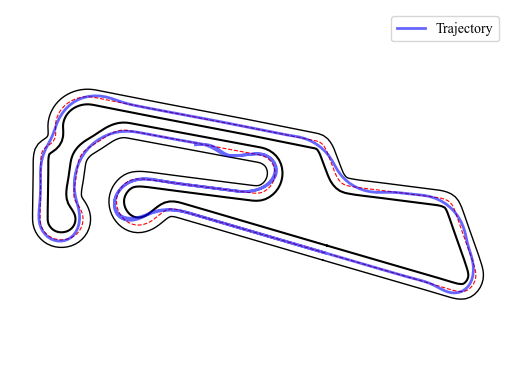

In [9]:
plt.figure()
plt.plot(state_history[0,:], state_history[1,:], 'b-', linewidth= 2, alpha =0.6, label = 'Trajectory')
ref_path.plot_track(linewidth = 1)
ref_path.plot_track_center(linewidth = 0.8, c='r')
plt.legend(prop={'size': 10})
plt.axis('equal')
plt.axis('off')
plt.show()

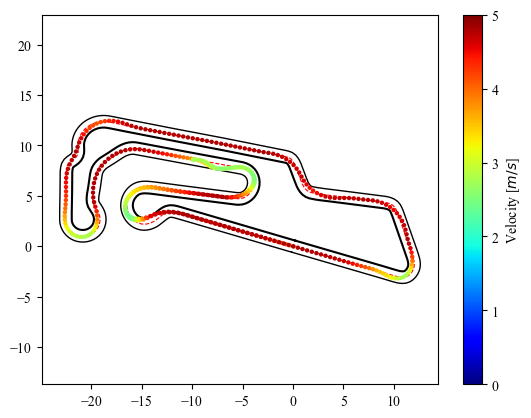

In [10]:
plt.figure()
ref_path.plot_track(linewidth = 1)
ref_path.plot_track_center(linewidth = 0.8, c='r')

sc = plt.scatter(state_history[0, :-1], state_history[1,:-1], s = 10, 
                c=state_history[2,:-1], cmap=cm.jet, 
                vmin=0, vmax=5, edgecolor='none', marker='o')
cbar = plt.colorbar(sc)
cbar.set_label(r"Velocity [$m/s$]", size=10)
plt.axis('equal')
plt.show()

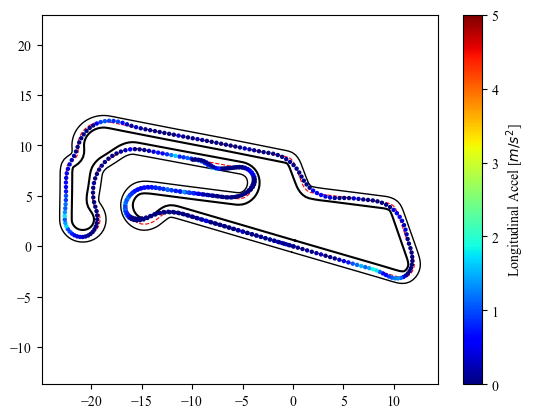

In [11]:
plt.figure()
ref_path.plot_track(linewidth = 1)
ref_path.plot_track_center(linewidth = 0.8, c='r')
sc = plt.scatter(state_history[0, :-1], state_history[1,:-1], s = 10, 
                c=control_history[0,:], cmap=cm.jet, 
                vmin=0, vmax=5, edgecolor='none', marker='o')
cbar = plt.colorbar(sc)
cbar.set_label(r"Longitudinal Accel [$m/s^2$]", size=10)
plt.axis('equal')
plt.show()

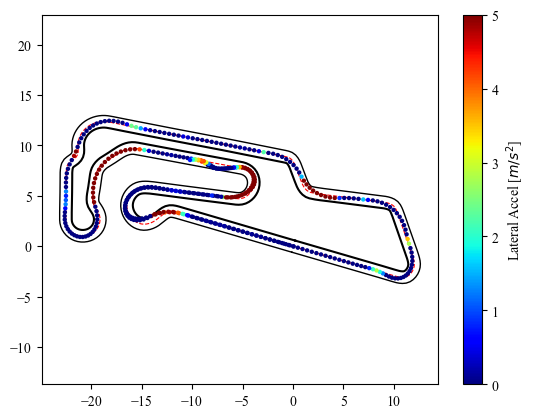

In [12]:
plt.figure()
ref_path.plot_track(linewidth = 1)
ref_path.plot_track_center(linewidth = 0.8, c='r')
alat = state_history[2,:]**2*np.tan(state_history[-1,:])/0.257
sc = plt.scatter(state_history[0, ], state_history[1,], s = 10, 
                c=alat, cmap=cm.jet, 
                vmin = 0, vmax=5, edgecolor='none', marker='o')
cbar = plt.colorbar(sc)
cbar.set_label(r"Lateral Accel [$m/s^2$]", size=10)
plt.axis('equal')
plt.show()

In [13]:
sim = plt.figure()
ref_path.plot_track()
plan_plot = plt.plot([], [], linewidth= 2)[0]
traj_plot = plt.scatter([], [], s = 10, c=[], cmap=cm.jet, vmin=0, vmax=5, edgecolor='none', marker='o')
cbar = plt.colorbar(traj_plot)
cbar.set_label(r"velocity [$m/s$]", size=20)
plt.axis('equal')
plt.close()

def drawframe(n):
    traj_plot.set_offsets(state_history[:2,:n+1].T)
    traj_plot.set_array(state_history[2,:n+1])
    plan_plot.set_data(plan_history[0,:, n], plan_history[1,:, n])
    
    return (traj_plot,plan_plot)


# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(sim, drawframe, frames=itr_receding, interval=ilqr.dt*1000, blit=True)
HTML(anim.to_html5_video())